## Perlin spontaneous

Copyright 2019 Sebastian Spreizer

The MIT License

In [1]:
%matplotlib notebook

import numpy as np
import nest
import pylab as pl

import lib.connectivity_map as cm
import lib.lcrn_network as lcrn
import lib.animation as animation
import lib.plot3d as pl3d
import lib.colormap as cmap

#### Perlin landscape for connectivity

<IPython.core.display.Javascript object>


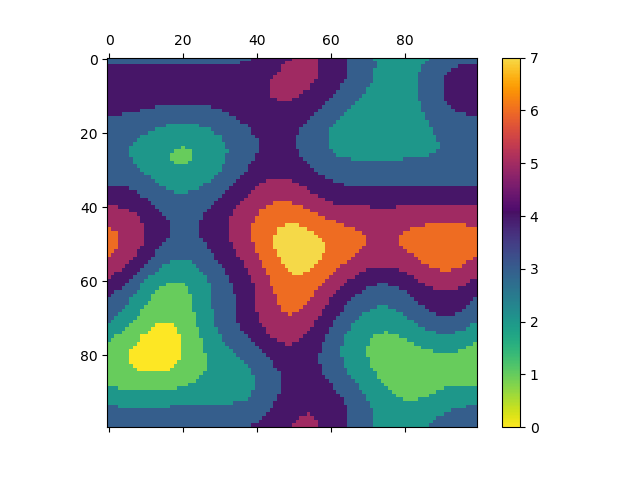

In [2]:
# Network size
nrow = ncol = 100
npop = nrow * ncol                 # amount of neurons in population

landscape = cm.Perlin(nrow, size=3)
landscape = np.round(landscape*7).astype(int)
move = cm.move(nrow)

fig,ax = pl.subplots(1,1)
im = ax.matshow(landscape.reshape(nrow,-1), cmap=cmap.virno())
pl.colorbar(im, ax=ax)

#### Set Kernel Status

In [3]:
np.random.seed(0)
nest.ResetKernel()
nest.SetKernelStatus({
    'local_num_threads': 4,
    'resolution': 0.1,
})

#### Create nodes

In [4]:
pop = nest.Create('iaf_psc_alpha', npop, params={
    "C_m":      250.0,
    "E_L":      -70.0,
    "V_reset":  -70.0,
    "V_th":     -55.0,
    "t_ref":      2.0,
    "tau_m":     10.0,
    "tau_minus": 20.0,
    "tau_syn_ex": 5.0,
    "tau_syn_in": 5.0,
})

# Create input devices
ng = nest.Create('noise_generator')

# Create recording devices
sd = nest.Create('spike_detector', params={
    'start':      0.0,
})

#### Connect nodes

In [5]:
offset = pop[0]
kappa = 4
theta = 3
shift = 1
ncon = 1000

# Connect neurons
for ii in range(npop):
    source = ii, nrow, ncol, nrow, ncol, ncon, kappa, theta
    targets, delay = lcrn.lcrn_gamma_targets(*source)
    if landscape is not None:          # asymmetry
        targets = (targets + shift * move[landscape[ii] % len(move)]) % npop
    # no selfconnections
    targets = targets[targets != ii]
    nest.Connect([pop[ii]], (targets + offset).tolist(), syn_spec={'weight': -10.0})

# Connect device to neurons
nest.Connect(ng, pop, syn_spec={'weight': 10.0})
nest.Connect(pop, sd)

#### Warming up

In [6]:
nest.SetStatus(ng, params={'std': 50.})
nest.Simulate(250.)
nest.SetStatus(ng, params={'mean': 70., 'std': 10.})
nest.Simulate(250.)

#### Start simulation

In [9]:
nest.SetStatus(ng, params={'mean': 70., 'std': 10.})
nest.Simulate(1000.)

#### Plot spiking activity

<IPython.core.display.Javascript object>


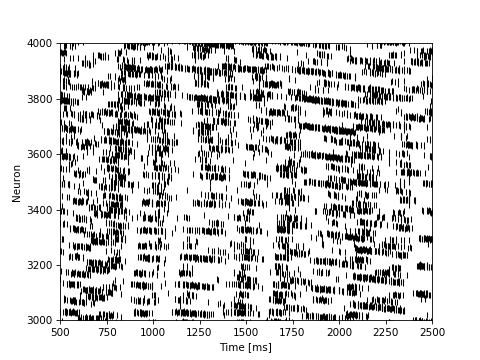

(500, 2500)

In [23]:
sdE = nest.GetStatus(sd, 'events')[0]
ts, gids = sdE['times'], sdE['senders']
fig, ax = pl.subplots(1,1, dpi=100)
ax.plot(ts, gids, 'k|')
ax.set_xlabel('Time [ms]')
ax.set_ylabel('Neuron')
i = 3000
ax.set_ylim(i,i+1000)
ax.set_xlim(500,2500)
#fig.savefig('sequence_raster_plot.pdf', dpi=300)

In [27]:
idx = gids - offset < npop
gids, ts = gids[idx], ts[idx]
time = nest.GetKernelStatus('time')

ts_bins = np.arange(time-1000., time, 50.)
h = np.histogram2d(ts, gids - offset, bins=[ts_bins, range(npop + 1)])[0]
hh = h.reshape(-1, nrow, ncol)

<IPython.core.display.Javascript object>


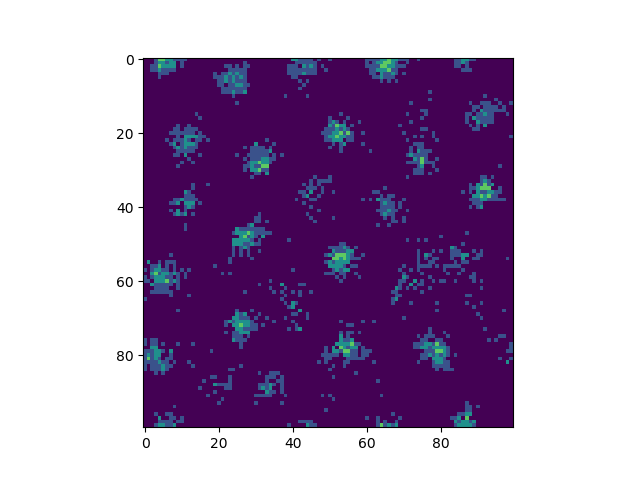

In [28]:
fig, ax = pl.subplots(1)
ax.imshow(hh[0], vmin=0, vmax=np.max(hh))

<IPython.core.display.Javascript object>


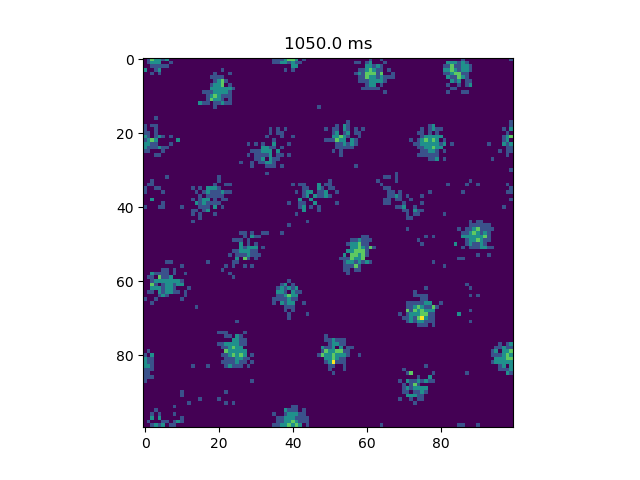

In [30]:
fig, ax = pl.subplots(1)
im = ax.imshow(hh[0], vmin=0, vmax=np.max(hh))

anim = animation.imshow(fig, ax, im, hh, ts_bins)

In [31]:
animation.HTML(anim.to_jshtml())

<IPython.core.display.Javascript object>


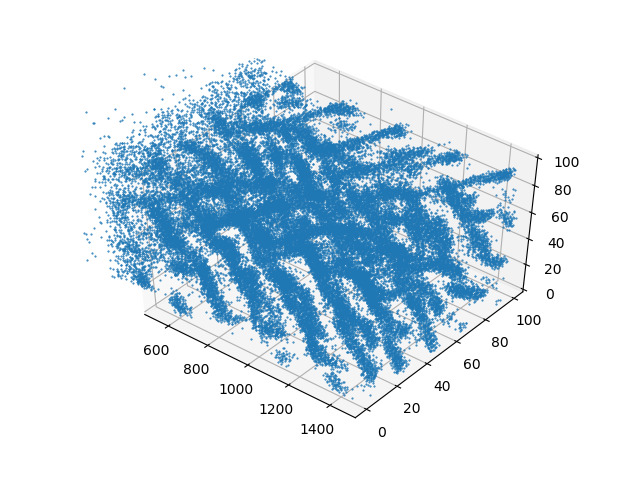

(500, 1500)

In [16]:
fig,ax = pl3d.scatter(ts,gids%nrow,gids//nrow)
ax.set_xlim(500,1500)